## installation, imports and helper functions

In [ ]:
#@title installing stuff and configure some things

#!pip install -q  torch peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 accelerate sacrebleu rouge-score OpenAI
!pip install -q  torch peft bitsandbytes transformers trl accelerate sacrebleu rouge-score OpenAI

# fix very strange bug...
import locale
locale.getpreferredencoding = lambda *_: "UTF-8"

# disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from IPython.display import display, HTML
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import json



import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    TrainerCallback,
    AutoModel
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
import sacrebleu
from rouge_score import rouge_scorer
from openai import OpenAI
from tqdm import tqdm
from numpy.linalg import norm

pd.options.display.min_rows = 20

OPENAI_API_KEY = "PUT YOUR API KEY HERE"

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [ ]:
#@title Data display function
def show(df, rows=7):
    # Display the DataFrame
    if rows == 0:
        rows = len(df)
    html_style = "<style>td{text-align: left !important;}</style>"
    html = df.to_html(justify="left", max_rows=rows, classes="my_table")
    display(HTML(html_style + html))


## load big bang dataset

In [ ]:
#@title unzip big bang dataset (upload first to colab, see link)

# using kaggle dataset
# not automized...
# download from here
# https://www.kaggle.com/datasets/mitramir5/the-big-bang-theory-series-transcript
# upload archive.zip

! unzip -n archive.zip

In [ ]:
#@title processing data
df = pd.read_csv("1_10_seasons_tbbt.csv")
df['scene_number'] = (df['person_scene'] == 'Scene').cumsum()
grouped = df.groupby('scene_number')

# Create an empty dataframe to store extracted information
extracted_scenes = pd.DataFrame(columns=df.columns)

MIN_HISTORY = 5

buffer = []
count = 0
for name, group in grouped:
    first = None
    for _, row in group.iterrows():
        if first is None:
            buffer = []
            first = row.copy()
            continue

        buffer.append(row.copy())
        if len(buffer) >= MIN_HISTORY and row['person_scene'] == 'Sheldon':
            buffer = buffer[-MIN_HISTORY:]
            buffer = [first] + buffer
            for r in buffer:
                r["instance"] = count
            extracted_scenes = extracted_scenes.append(buffer)
            # Clear buffer and reset count
            buffer = []
            count += 1

# Reset index
extracted_scenes.reset_index(drop=True, inplace=True)
show(extracted_scenes)

In [ ]:
#@title bringing data in final shape
def create_context(rows):
    rows = rows.reset_index(drop=True)
    context = f"Scene: {rows.iloc[0]['dialogue']}\n\n"
    context += "\n".join(f"{row['person_scene']}: {row['dialogue']}" for _, row in rows.iloc[1:-1].iterrows())
    context += "\nSheldon: "
    label = rows.iloc[-1]['dialogue']
    return context, label

dataset = pd.DataFrame(columns=['input', 'label'])
dataset[['input', 'label']] = extracted_scenes.groupby("instance").apply(create_context).apply(pd.Series)
show(dataset)

In [ ]:
#@title Save dataset as csv
data_name = "sheldon.csv"
dataset.to_csv(data_name, index=False)

## Load Gordon Ramsay dataset

In [ ]:
#@title Load dataset from our spreadsheet into pandas dataframe

# google credentials for automatic access to the spreadsheet with the training data
google_credentials = """
PUT YOUR CREDENTIALS HERE
"""

credentials_dict = json.loads(google_credentials, strict=False)

# Set up credentials
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_dict(credentials_dict, scope)
client = gspread.authorize(creds)

# Open the Google Sheets document by its title
spreadsheet = client.open("Gordon Ramsay Training Data")

# Select a specific worksheet
worksheet = spreadsheet.get_worksheet(0)  # Use the index of the sheet, starting from 0

# Get all values from the worksheet
data = worksheet.get_all_values()
data = np.array(data)

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data[1:,:4], columns=data[0,:4])

show(df)

,Question,Response,Source Number,Filter
0,What is your name?,Dude you should know my name!,0,X
1,"One person, could be anyone, to make you pancakes for the rest of your life.","I have so many great breakfast-makers in my life between my wife, Tana, my mum and the kids. But I’d have to say my daughter Tilly. She knows how to cook them (and make the perfect mess)!",2,
2,How many close calls did you have before you could successfully carve a chicken blindfolded?,None! But I certainly did not move that quickly on my first couple of attempts. I need all ten fingers.,2,
...,...,...,...,...
168,Can you tell us a little more about the experts you consulted in the show?,"The experts were paramount across this competition because they really gave the contenders an insight. These experts were in their shoes five, six years ago - look at Ben Branson, the creator of Seedlip, that guy was developing these cocktails in the back of his mother's kitchen on their farm as early as 2014, and within five years became a huge, huge industry success. Again, Will Shu one of the founders of Deliveroo, developed the app while he was living above a little greasy spoon cafe down the Kings Road, and it didn't really implode until 2010. Getting up to Daylesford and seeing how a farm should be, in an amazing position to offer farm-to-table best produce, again, it was an amazing challenge and great produce. We were very lucky to work with those leading experts. Love the Taco Boys and the humble approach that these two kids have; they were young chefs who set up a taco shack on the beach at 21 and 22 years of age, with a product that is there and then gone - these things were sold out before the end of the queue finished. I believe it really helped Future Food Stars come to life working with those experts because it gave the show so much gravitas.",16,
169,The contenders don’t always see eye to eye. Were you surprised at the level of tension amongst them? Does tension always equal passion?,"You know, in any business, there's always tension and there's pressure. I've always adapted to handling that pressure. They were super competitive, and differences were inevitable. They are all strong, independent characters - that’s why they are successful in what they do, running their different independent businesses. Ultimately, I wanted them to focus on the challenges ahead and stay focused on that prize, which they did.",16,X
170,What advice would you give to any future food stars wanting to get investment?,"My advice is, to ask yourself if your business is at the forefront of the competition. What can you do to change it? Are you ready to take a quantum leap and get this business catapulted? The secret behind any great success is the art of delegation. Are they willing to let go of some of the independence and control in their brand in order to take on that help? And if they can accept that and maintain their quality and focus then the sky's the limit!",16,


In [ ]:
#@title Exclude some of the data marked with an "x"
df = df[(df["Filter"] != "x") & (df["Filter"] != "X")].reset_index(drop=True)
show(df)

,Question,Response,Source Number,Filter
0,"One person, could be anyone, to make you pancakes for the rest of your life.","I have so many great breakfast-makers in my life between my wife, Tana, my mum and the kids. But I’d have to say my daughter Tilly. She knows how to cook them (and make the perfect mess)!",2,
1,How many close calls did you have before you could successfully carve a chicken blindfolded?,None! But I certainly did not move that quickly on my first couple of attempts. I need all ten fingers.,2,
2,The first attempt at a dish that went completely awry?,"Like everything in life, learning to cook is all about the failure of your attempts. You have to be resilient and dust yourself down and go again. This came in handy when I made my first salted caramel soufflé. What a disaster!",2,
...,...,...,...,...
129,"You film in some stunning locations across the UK, can you tell us a little more about them?","The UK has got such beauty when it comes to filming and it lends itself to such amazing photography. We open up the show in Newquay - that place has been my family's exciting little haven over the last 10 years since we fell in love with Cornwall a decade ago. Filming out in the Lake District and doing the challenge designed for the first responders, the Mountain Rescue Team, was breathtaking, absolutely breathtaking. We also filmed down in Devon and Somerset's Cheddar Gorge, doing a challenge locating cheese in these amazing caves which was beautiful, really beautiful. And then of course, London. We're spoilt for choice when it comes to stunning architecture and locations in London. The power and energy of the city just helps drive the contestants to push even harder.",16,
130,Can you tell us a little more about the experts you consulted in the show?,"The experts were paramount across this competition because they really gave the contenders an insight. These experts were in their shoes five, six years ago - look at Ben Branson, the creator of Seedlip, that guy was developing these cocktails in the back of his mother's kitchen on their farm as early as 2014, and within five years became a huge, huge industry success. Again, Will Shu one of the founders of Deliveroo, developed the app while he was living above a little greasy spoon cafe down the Kings Road, and it didn't really implode until 2010. Getting up to Daylesford and seeing how a farm should be, in an amazing position to offer farm-to-table best produce, again, it was an amazing challenge and great produce. We were very lucky to work with those leading experts. Love the Taco Boys and the humble approach that these two kids have; they were young chefs who set up a taco shack on the beach at 21 and 22 years of age, with a product that is there and then gone - these things were sold out before the end of the queue finished. I believe it really helped Future Food Stars come to life working with those experts because it gave the show so much gravitas.",16,
131,What advice would you give to any future food stars wanting to get investment?,"My advice is, to ask yourself if your business is at the forefront of the competition. What can you do to change it? Are you ready to take a quantum leap and get this business catapulted? The secret behind any great success is the art of delegation. Are they willing to let go of some of the independence and control in their brand in order to take on that help? And if they can accept that and maintain their quality and focus then the sky's the limit!",16,


In [ ]:
#@title find out longest answer in training to know the max tokes we need to generate. (This has answer has about 400 tokens)
print(max(df["Response"], key=len))

Yes, I found one guy in a Greek restaurant this year who was almost I suppose constantly sort of shot down by his dad that in his eyes, he could never step up to the plate. This guy ran the service like we never expected. Honestly this guy was almost sort of becoming a bit of a sort of filler in, run around and in his early 30s was a bit of a go-for for his dad and never really had an identity, so the staff in that restaurant didn’t take him serious. So, yes, this was amazing because I’d never seen anyone run a hot plate and coordinate a kitchen and multi-task the way he did. He just snapped into it almost like he’d been trained for six months to gear up for that one night. And he kept it all in and it just went crazy. It was an amazing thing to see. But we come across these little gems and they are few and far between. I can’t absolutely ever put money into these restaurants because that’s a production thing. I can’t be seen to favor one. I can’t be seen to employ any of them either, 

In [ ]:
#@title Turn data into llama format and save as CSV

def data_to_llama_format(model_input, model_output=None, system_message=None):
    result = "<s>[INST] "
    if system_message is not None:
        result += "<<SYS>>\n" + system_message + "<</SYS>>\n\n"
    result += model_input + " [/INST] "
    if model_output is not None:
        result += model_output
    return result


data_name = "train_ramsay.csv"

df["text"] = data_to_llama_format(df["Question"], model_output=df["Response"])
df["input"] = df["Question"]
df["label"] = df["Response"]
df.to_csv(data_name, index=False)

df["text"][0]

'<s>[INST] One person, could be anyone, to make you pancakes for the rest of your life. [/INST] I have so many great breakfast-makers in my life between my wife, Tana, my mum and the kids. But I’d have to say my daughter Tilly. She knows how to cook them (and make the perfect mess)!'

## Perform train test split

In [ ]:
#@title load dataset
# Dataset
full_dataset = load_dataset("csv", data_files=data_name, split="train")

# splitted_dataset = full_dataset.train_test_split(test_size=.02, seed=42)
splitted_dataset = full_dataset.train_test_split(test_size=.15, seed=42)

training_data = splitted_dataset["train"]
testing_data = splitted_dataset["test"]

training_data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Question', 'Response', 'Source Number', 'Filter', 'text', 'input', 'label'],
    num_rows: 113
})

## Load and setup model

In [ ]:
#@title Download the model (llama2) This usually takes some time

# Model and tokenizer names
base_model_name = "NousResearch/Llama-2-7b-hf"
# base_model_name = "NousResearch/Llama-2-7b-chat-hf"


# Quantization Config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False
)

# Model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=quant_config,
    device_map={"": 0}
)

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token

# llama_tokenizer.padding_side = "right"  # Fix for fp16
# base_model.config.use_cache = False
# base_model.config.pretraining_tp = 1


base_model = prepare_model_for_kbit_training(base_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [ ]:
#@title Prompt format and Generation settings


from transformers import StoppingCriteriaList, StoppingCriteria
# the tokenizer is hard to work with because the tokenization of "\nQuestion:" depends on whatever was before...
# thats why I use [3:] to cut the first part of the tokenized sequence and hope that the rest will be the same no matter of what came before
# this seems to work
stop_words_ids = [
    llama_tokenizer(stop_word, return_tensors='pt').to("cuda:0")['input_ids'].squeeze()[3:] for stop_word in ["\nQuestion:"]
    ]

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = []):
        StoppingCriteria.__init__(self),
        self.stops = stops

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for seq in input_ids:
            for stop in self.stops:
                if len(seq) >= len(stop) and torch.all((stop == seq[-len(stop):])).item():
                    return True
        return False


from transformers import StoppingCriteriaList
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])


generation_params = {
    "task": "text-generation",
    "model": base_model,
    "tokenizer": llama_tokenizer,
    "max_new_tokens": 500,
    "return_full_text": False,
    "repetition_penalty": 1.2,
    "temperature": .7,
    "stopping_criteria": stopping_criteria,
}


# system_prompt = "Complete Sheldons response"
system_prompt = "Answer as Gordon Ramsay"

# gpt_system_prompt = "You are Sheldon Cooper. Write his response, which is usually short."
gpt_system_prompt = "Answer as Gordon Ramsay in one to five sentences."

# response_template = "[/INST]"
response_template = "Response:"

# def formatting_prompts_func(example, system_prompt=system_prompt):
#     output_texts = []
#     for i in range(len(example['input'])):
#         if system_prompt != "":
#           text = f"<s>[INST] <<SYS>>{system_prompt}<</SYS>>\n\n{example['input'][i]}\n[/INST] {example['label'][i]}"
#         else:
#           text = f"<s>[INST] {example['input'][i]}\n[/INST] {example['label'][i]}"
#         output_texts.append(text)
#     return output_texts

def formatting_prompts_func(example, system_prompt=system_prompt):
    output_texts = []
    for i in range(len(example['input'])):
        text = f"Question: {example['input'][i]}\nResponse: {example['label'][i]}"
        output_texts.append(text)
    return output_texts


# Generate Text
def answer(question, system_prompt=system_prompt, **kwargs):
    params = generation_params.copy()
    params.update(kwargs)
    text_gen = pipeline(**params)
    data = {"input": [question], "label":[""]}
    formatted_data = formatting_prompts_func(data, system_prompt=system_prompt)[0]
    output = text_gen(formatted_data)
    output = output[0]['generated_text'].split("\nQuestion:")[0]
    if len(llama_tokenizer(output)) >= generation_params['max_new_tokens']:
        print("warning: max tokens reached in output")
    return output

In [ ]:
show(training_data.to_pandas()[['input', 'label']])

,input,label
0,"Putting you on the spot, have you given your legacy much thought?","Fucking hell. That's a big question. Legacy? I think my legacy would be the plethora of talent that I've had the pleasure to work with, they’re now laying the foundation of the future. Oh, and whether I’m in a tapas bar on the backstreets of Barcelona or the arse-end of the jungle, someone wants to talk to me about my fucking beef Wellington. As for what I'd like to be remembered for... I'd like to be remembered for perfection. Because it's an absolute bitch to get right, but when it is, it's the most beautiful fucking thing on the planet."
1,A meal when you weren’t expecting much but were absolutely blown away.,"I was in New Zealand filming my National Geographic show and I had a few days down in Auckland. We went down this alleyway to this restaurant in a basement called Cassia, and it had the most incredible modern Indian food. If there was a Michelin Guide in Auckland, that spot would have it."
2,Twenty four hours is a really short period of time to turn a restaurant around. Why did you pick that time frame?,"You’ll be surprised what you can do after three decades in this business in 24 hours. We do our due diligence, we do our homework constantly and then we come up with a plan, a conceptualized plan before we get here. So the good news is that we’re sorta rigging these businesses, for two to three weeks, with CCTV cameras. We get all the footage, condensed. I know where all the bodies are buried and then I can get straight to work. So, yeah, it’s twenty-four hours, but it’s almost like a week’s work."
...,...,...
110,There was a recent interview in the London Times where the writer was saying that he didn’t think you were taking the move to New York as seriously as you should. What was your reaction to that?,"I don’t underestimate the challenge in New York, but I’m not as intimidated. I’ve been to hell and back to get where I am today at the age of 40, and the challenges were extraordinary. When I learn and eat out the way I do, constantly going into Jean-Georges and Daniel and Per Se and Masa and the Modern - phenomenal chefs, phenomenal chefs - but I don’t feel that I’m out of their league. They’ve been here as part of the building infrastructure for years and I’m the new kid on the block, someone to scrutinize twice as much so any little mistake becomes a big mistake. I shouldn’t be making mistakes; however, I do. I’m genuine and I don’t underestimate a challenge and I know that it’s a daunting task, but I love that level of jeopardy. I’m at my best under pressure. I can’t function unless I have it. If I’m taking it easy, I’m not interested. I want the best of the best, and there’s a price to pay for that, so no, the challenge is daunting but exciting. I’m still going to sleep with one eye open, trust me."
111,Are there any tricks of the trade you can share with us? How do you know when the time is right to drop the f-bomb?,"No, no, no. I'm completely unedited. When it comes, it comes. Nobody tells me what to say or when to say it, it just comes out."
112,"Tell us the truth: is it a hassle having to fly around the world, visiting your restaurants and doing these interviews?","It’s a happy problem. It’s all about time management. This time last week I was in Costa Rica diving with bull sharks. Now I’ve got a grip on my diary, I’m actually doing less and doing what I have left to do better."


## Test the loaded model

In [ ]:
print(answer("One person, could be anyone, to make you pancakes for the rest of your life."))

100% my mum! She’s a great cook and she makes amazing pancakes with bacon on top. I love them so much that when we were in America last year, I had one every day at breakfast time. It was like an obsession – but they weren’t as good as hers.


## Setup accuracy measurements

In [ ]:
#@title loading embedding model for embedding distance accuracy

# current sota text embedding model (bert architecture)
embedding_model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True) # trust_remote_code is needed to use the encode method

In [ ]:
#@title function to measure bleu, rouge and embedding distance
tqdm.pandas()
client = OpenAI(api_key=OPENAI_API_KEY)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)

# store generated output of evaluations to be able to look over them later
model_outputs = testing_data.to_pandas().copy(deep=True)[['input', 'label']]

def get_bleu(pred, label):
    return sacrebleu.corpus_bleu([pred], [[label]]).score/100

def get_rouge(pred, label):
    scores = scorer.score(label, pred)
    return np.mean([s.precision for s in scores.values()])

def get_embedding_similarity(pred, label):
    pred_emb, label_emb = embedding_model.encode([pred, label])
    dot_similarity = np.dot(pred_emb, label_emb)
    cos_similarity = dot_similarity/ (norm(pred_emb) * norm(label_emb))
    return cos_similarity, dot_similarity

def evaluate_model(awnser_method, save_results=None):
    df = testing_data.to_pandas()
    # without_answers = df.copy()
    # without_answers['label'] = ""
    # df['text'] = formatting_prompts_func(without_answers)

    df['pred'] = df['input'].progress_apply(awnser_method)
    # from random import random
    # df['pred'] = [(label if random()<.5 else 'I am not Gordon Ramsay') for label in df['label']]

    if save_results is not None:
        model_outputs[save_results] = df['pred'].copy()

    ev = lambda fun: (lambda row: fun(row['pred'], row['label']))
    df['bleu'] = df.apply(ev(get_bleu), axis=1)
    df['rouge'] = df.apply(ev(get_rouge), axis=1)
    df['similarity'] = df.apply(ev(get_embedding_similarity), axis=1)
    df['cos_similarity'] = df["similarity"].apply(lambda x: x[0])
    df['dot_similarity'] = df["similarity"].apply(lambda x: x[1])

    stats = df['bleu'].mean(), df['rouge'].mean(), df['cos_similarity'].mean(), df['dot_similarity'].mean()
    print(f"Bleu: {stats[0]}, Rouge: {stats[1]} Cos Similarity: {stats[2]} Dot Similarity: {stats[3]} Mean: {np.mean(stats)}")
    return stats

In [ ]:
#@title GPT-3.5 Turbo API call
# instruct_prompt = "You are Sheldon Cooper. Write his response, which is usually short."
def gpt_3_answer(text, system_prompt=None):
    messages = []
    if system_prompt:
        messages += [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}],
        }
    ]
    messages += [
        {
            "role": "user",
            "content": [{"type": "text", "text": text}],
        }
    ]
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=generation_params['max_new_tokens'],
    )
    return response.choices[0].message.content

In [ ]:
#@title test openai api call
gpt_3_answer("One person, could be anyone, to make you pancakes for the rest of your life.", system_prompt=gpt_system_prompt)

"These pancakes are an absolute disgrace! They're undercooked, rubbery, and practically flavorless. It's an insult to call this cooking. You couldn't pay me to eat these for the rest of my life."

In [ ]:
#@title store evaluation results
evaluation_results = {
    "base llama": [0.008825346003609846, 0.22769520371946975, 0.8098319172859192, 150.72434997558594],
    "instructed llama": [0.009552554836528558, 0.24490193502317564, 0.8018774390220642, 150.07127380371094],
    "instructed GPT 3.5": [0.04536359184711902, 0.41137333123323727, 0.8733572779418028, 0],
    "fine-tuned llama (ours)": [0.010482740836124457, 0.15966477626383907, 0.7388901114463806, 144.7965545654297]

}

## Run accuracy measurements for baselines

In [ ]:
#@title (instruction fine-tuned) llama without instruction, just answer
evaluation_results["base llama"] = evaluate_model(lambda x: answer(x, system_prompt=""), save_results="base llama")

  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
 48%|████▊     | 10/21 [03:44<04:57, 27.01s/it]

In [ ]:
#@title llama 2 instructed to awnser as Sheldon
evaluation_results["instructed llama"] = evaluate_model(answer, save_results="instructed llama")

  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 21/21 [06:41<00:00, 19.13s/it]


Bleu: 0.008674623400277966, Rouge: 0.2389677800449639 Cos Similarity: 0.7875950932502747 Dot Similarity: 147.0535430908203 Mean: 37.02219514687896


In [ ]:
#@title GPT 3.5 Turbo instructed to awnser as Gordon Ramsay
evaluation_results["instructed GPT 3.5"] = evaluate_model(lambda text: gpt_3_answer(text, system_prompt=gpt_system_prompt), save_results="gpt-3.5 turbo")

100%|██████████| 21/21 [00:59<00:00,  2.86s/it]


Bleu: 0.013631734582422238, Rouge: 0.12768891335251928 Cos Similarity: 0.7876684069633484 Dot Similarity: 152.0545196533203 Mean: 38.24587717705465


,input,label,ours,gpt-3.5 turbo
0,"In the very first challenge, one of the conten...",The scariest thing I've ever done was leaping ...,10 years ago I was in a car accident and my sp...,"Well, let me tell you, the scariest thing I've..."
1,You are talking now about running a restaurant...,"Ah, well I enjoy cooking no matter which city ...",100%. It’s the same thing for me as it is for ...,I have a deep personal relationship with food ...
2,Most annoying question you’re asked in intervi...,Whether I hate vegetarians.,100% “What is your biggest weakness?” I hate t...,The most annoying question I get asked in inte...
3,Stand-up comic Patton Oswalt has a theory that...,"Yes, absolutely. Chefs are nutters. They're al...",100 percent! I think it’s the only thing that ...,"Oh, please! That's a load of baloney! Great ch..."
4,How about Dubai? Do you still enjoy coming here?,Dubai means a huge amount to me. Verre is 10 y...,100%. I love it. It’s a great place to come an...,"Dubai, it's like visiting a culinary desert. T..."
5,How do you manage serving both restaurants and...,The only way to describe the kitchen is... eno...,"10 years ago, we had a separate kitchen for ea...","In my opinion, managing both restaurant and ro..."
6,When you’ve woken up before someone else to pr...,Wakey wakey!!! Let’s get this day started on t...,1. I want to show my love and care for her by ...,"Good morning, you lazy donkey! I've slaved awa..."
7,What is the hardest thing to fix at a restaurant?,The hardest thing for me to fix when we take o...,"1. The kitchen, because it’s so hot and you ha...",The hardest thing to fix at a restaurant is th...
8,"So, aged 22, what set you apart from the rest?",I had this raw instinct. Every time I accepted...,10 years of experience. I’ve been doing this f...,"At the young age of 22, I was already determin..."
9,"One person, could be anyone, to make you panca...",I have so many great breakfast-makers in my li...,100% my mum! She’s a great cook and she makes ...,"Oh, my goodness, don't even get me started on ..."


## Fine tune model

In [ ]:
class eval_callback(TrainerCallback):
    def __init__(self):
        self.epoch=1
    def on_epoch_end(self, *args, **kwargs):
        evaluate_model(lambda x: answer(x, model=fine_tuning.model), save_results=f"train_epoch_{self.epoch}")
        self.epoch += 1

# LoRA Config
peft_parameters = LoraConfig(
    lora_alpha=8,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    # target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'lm_head'],
)

base_model = get_peft_model(base_model, peft_parameters)

# Training Params
train_params = TrainingArguments(
    output_dir="fine_tuned",
    overwrite_output_dir=True,
    num_train_epochs=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    max_grad_norm=0.3,
    save_total_limit=4,
    lr_scheduler_type="constant",
)

response_template_with_context = "\n" + response_template
response_template_ids = llama_tokenizer.encode(response_template_with_context, add_special_tokens=False)[1:]
collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=llama_tokenizer)

# Trainer
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=training_data,
    peft_config=peft_parameters,
    tokenizer=llama_tokenizer,
    # callbacks=[eval_callback],
    args=train_params,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

# Training
fine_tuning.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/113 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:247: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It 

Step,Training Loss


TrainOutput(global_step=15, training_loss=2.5524169921875, metrics={'train_runtime': 117.4867, 'train_samples_per_second': 0.962, 'train_steps_per_second': 0.128, 'total_flos': 1459297500659712.0, 'train_loss': 2.5524169921875, 'epoch': 1.0})

## Run accuracy measurements for our fine-tuned model

In [ ]:
print(base_model)

In [ ]:
evaluation_results["fine-tuned llama (ours)"] = evaluate_model(answer, save_results="ours")

  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_ree

Bleu: 0.011784794367496973, Rouge: 0.1791360772352659 Cos Similarity: 0.7690221071243286 Dot Similarity: 145.35617065429688 Mean: 36.579028408255994


## Analyze Results

In [ ]:
model_outputs.to_csv("result_gordon.csv")

In [ ]:
#@title Show all evaluation Generations
show(model_outputs, rows=0)

,input,label,ours
0,"In the very first challenge, one of the contenders mentions that jumping off the cliff is the scariest thing they have ever done. What’s the scariest thing you have ever done?","The scariest thing I've ever done was leaping out of a helicopter at 300 feet, in the depth of the Amazon jungle that was laden with crocodiles. Halfway through the descent, I was hoping these things were going to move and jump back into the water, but they stayed there till I was about 10 feet away. As soon as I unclipped and dropped down onto the sand, in the middle of Guyana on the northwest tip of the Amazon jungle, I think they got slightly spooked and dived back into the water. So yeah, it was the kind of rappel that you couldn't stop halfway down or ask the helicopter to move on. Once you’ve committed, you’re doing it, no going back!",10 years ago I was in a car accident and my spine got crushed from the impact. It took me about two months to get out of hospital but it left me with no feeling below my waist for three weeks. That was pretty terrifying!
1,"You are talking now about running a restaurant. I was actually referring to your personal relationship with food, with products.","Ah, well I enjoy cooking no matter which city I am in. But the challenge in Paris is the biggest. Getting three stars in London was already hugely ambitious, but three stars in Paris is an exceptional achievement for any chef. I know what I’m talking about because I used to work there. If I can put down there what I have achieved in London, I’m a happy bunny.","100%. It’s the same thing for me as it is for you and everyone else in this room. We all have our own individual tastes when we go out eating or cooking at home. And that’s what makes us who we are. That’s why I love going into restaurants where they do something different from my style of cooking because then I can learn more about myself by learning how other people approach things differently than I would. So yeah, absolutely. My whole life has been based around food. Whenever I get asked questions like “What did you want to be?” I always say chef. Because if there’s one job that I could see myself doing every day until I die, it’d probably be being a chef."
2,Most annoying question you’re asked in interviews?,Whether I hate vegetarians.,"100% “What is your biggest weakness?” I hate this question. It makes me feel like the interviewers are trying to catch me out and make me look bad, which isn’t a great way for them to start off an interview! My answer would be that my attention span can sometimes wander when there aren’t any interesting things going on around me – but it doesn’t mean I don’t care about what I do or am not interested in learning new skills/ways of doing something better."
3,"Stand-up comic Patton Oswalt has a theory that all great chefs are in some way clinically insane, either because of O.C.D. or some dark obsession that haunts them. Do you agree?","Yes, absolutely. Chefs are nutters. They're all self-obsessed, delicate, dainty, insecure little souls and absolute psychopaths. Every last one of them.","100 percent! I think it’s the only thing that makes people want to be good at something and do things over and over again until they get better. It’s like an addiction; if you don’t have any other kind of drive for anything else, then cooking is your drug. You can’t stop doing it once you start. And when you become obsessed with food, there’s no turning back from that. There’s nothing more important than what goes into my mouth right now. That’s why I eat so much shit—I just love eating. If someone were to say, “You know what would make me happy?” I wouldn’t even need to ask him twice before he said, “Food.”\nQ: What about you? Are you a chef who likes to eat out? Or does dining out feel too much like work?\nA: No, not really. Whenever we go on holiday somewhere, I always try to find restaurants where I can learn as well. We went to New York recently and had dinner at Mo

In [ ]:
evaluation_results['base llama'] = [0.0071028143356097985, 0.24531115014953658, 0.7618087530136108, 146.41720581054688]

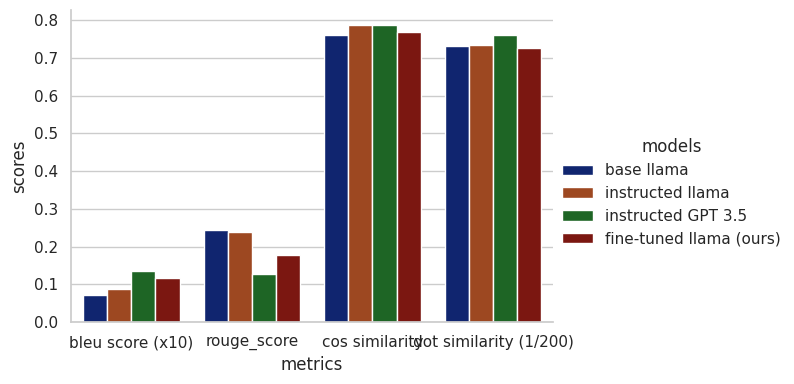

In [ ]:
#@title Plot Accuracy results
import seaborn as sns


# plot data as a bar chart with grouped bars (grouped my metric)
# with all scores for each model next to each other
results_metrics = ["bleu score (x10)", "rouge_score", "cos similarity", "dot similarity (1/200)"]
sns.set_theme(style="whitegrid")

result_scores = []
for model in evaluation_results:
    result_scores.append(evaluation_results[model])

result_scores = np.array(result_scores)
result_scores = np.transpose(result_scores)

result_scores = pd.DataFrame(result_scores, columns=evaluation_results.keys())
result_scores.iloc[0] *= 10
result_scores.iloc[3] /= 200
result_scores["metrics"] = results_metrics
result_scores = result_scores.melt("metrics", var_name="models", value_name="scores")


g = sns.catplot(
    data=result_scores, kind="bar",
    x="metrics", y="scores", hue="models", palette="dark", height=4, aspect=1.5,
)
# plt.yscale("log")


In [ ]:
print(answer("Scene: The stairs of the apartment building.\n\nLeonard: Hi. Well, uh, oh, welcome to the building.\nPenny: Thankyou, maybe we can have coffee sometime.\nLeonard: Oh, great.\nPenny: Great.\n   Sheldon:"))

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

 Leonard! I'm glad you could make it.
Leonard: Hey, guys. How are things?
Sheldon: We were just talking about how much fun it is when Penny comes over and talks with us like normal people instead of some kind of weirdo.
Leonard: Yeah, well, she seems nice enough.
Raj: She does seem very nice.
Howard: You know what else would be really cool? If she came


In [ ]:
print(answer("Scene: Living room, Sheldon is sleeping on the sofa, with his head on Lesley’s Violin case.\n\nSheldon: I don’t come into your house and touch your board.\nLesley: There are no incorrect equations on my board. \nSheldon: Oh, that is so… so…\nLesley: I’m sorry, I’ve got to run, if you come up with an adjective, text me. (Leaves).\n   Sheldon:"))

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

 (Sigh)

Scene: The living room of Penny's apartment. Leonard and Penny are sitting together watching TV.

Penny: So what do we think?

Leonard: Well, it was nice meeting her. She seems like she could be fun. But...

Penny: Yeah, but?

Leonard: It just felt weird being in there alone with her. Like, I didn't know how


In [ ]:
print(answer("Scene: The apartment.\n\nPenny: You didn’t tell her we were going out, did you?\nLeonard: Um…\nPenny: Why not?\nLeonard: Um…\n   Sheldon:"))

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

 I don't know why he doesn't just say it! He's so bad at this!
Sheldon: Well, Leonard and Penny are on their way to the movies.
Raj: Oh my God! They finally went there!
Howard: Yeah, they're gonna see "The Avengers."
 Raj: That is awesome!
 Howard: It was actually pretty good.
 Raj: Really?
 Howar d :Y


In [ ]:
print(answer("Scene: A few moments later.\n\nHoward: I’m guessing that future historians will condemn us for not taking this opportunity to kill Sheldon.\nPenny: Okay, I have a question.\nSheldon: Yes, Penny.\nPenny: You don’t even like people touching you. How are you going to have sex?\n   Sheldon:"))

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

 * I am an expert in the field of human sexuality and can assure you it is possible without physical contact.
    * It's called "sex."
Leonard: Well, if he doesn't want to be touched then how do we know what his preferences are?
Rajesh: Oh my God! He wants me to go down on him while he watches porno movies with Howard.
Amy: That sounds about right.
Scene
